In [ ]:
# Requirements
!pip install torch pandas efficientnet-pytorch skorch

In [ ]:
# Imports

# python libraties
%matplotlib inline
import matplotlib
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from skimage import io, transform
import pickle
import seaborn as sn


# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from torchvision import transforms
from efficientnet_pytorch import EfficientNet

# skorch libraries
import skorch
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from skorch.callbacks import Freezer
from skorch.callbacks import Checkpoint
from skorch.callbacks import Callback
from skorch.callbacks import EarlyStopping
from skorch.helper import predefined_split
from skorch.dataset import Dataset

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())
data_dir = '/content/drive/MyDrive/sanj/ISIC 2018/'
# data_dir = './ISIC 2018/'

/content


In [ ]:
# Inspect gold standard lesion diagnosis
df = pd.read_csv(os.path.join(data_dir,'ISIC2018_Task3_Training_GroundTruth.csv'))
df.head(3)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Specify what the acronyms mean
lesion_type_dict = {
    'MEL': 'Melanoma',
    'NV': 'Melanocytic nevi',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses', # Corrected from 'AK'
    'BKL': 'Benign keratosis-like lesions',
    'DF': 'Dermatofibroma',
    'VASC': 'Vascular lesions'
}

In [ ]:
df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create column dx in our dataframe to hold diagnosis acronyms
# df = pd.read_csv(os.path.join('ISIC_2019_Training_GroundTruth.csv'))
df = df.set_index('image')
# df = df.drop(['UNK'],axis=1)  # On this occasion we won't use this column.
i, j = np.where(df)
dx = pd.Series(df.columns[j], i)
dx_df = pd.Series.to_frame(dx)
df = df.reset_index()
df_original = pd.concat([df, dx_df], axis=1, sort=False)
df_original = df_original.rename(columns={0: "dx"})
df_original.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
5,ISIC_0024311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
6,ISIC_0024312,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
7,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
8,ISIC_0024314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
9,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL


In [ ]:
# Create column path to store each image path
data_dir = '/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018_Task3_Training_Input'
all_image_path = glob(os.path.join(data_dir, 'ISIC2018_Task3_Training_Input', '*.jpg'))
print(f"All image paths found: {len(all_image_path)}")

# Create dictionary where key is the pure image ID (e.g., 'ISIC_0000000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
print(f"Dictionary keys created: {list(imageid_path_dict.keys())[:5]}...")

# --- Path Mapping Correction ---
# **STEP 1: Create a pure image ID column from the 'image' column.**
# This accounts for cases where df_original['image'] might contain 'ISIC_XXXXX.jpg'
df_original['image_id_pure'] = df_original['image'].apply(lambda x: os.path.splitext(str(x))[0])

# **STEP 2: Map the paths using the pure ID**
df_original['path'] = df_original['image_id_pure'].map(imageid_path_dict.get)

# Optional: Drop the intermediate column
df_original = df_original.drop(columns=['image_id_pure'])
# --- End of Path Mapping Correction ---

# Create column cell_type to store the full diagnosis
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

# Create column lesion_code to store lesion codes
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

print(f"Number of rows with missing paths: {df_original['path'].isnull().sum()}")
df_original.head(3)

All image paths found: 10028
Dictionary keys created: ['ISIC_0033293', 'ISIC_0033327', 'ISIC_0033278', 'ISIC_0033296', 'ISIC_0033288']...
Number of rows with missing paths: 0


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


In [ ]:
df_original.columns

Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC', 'dx', 'path',
       'cell_type', 'cell_type_idx'],
      dtype='object')

In [ ]:
#df_original = pd.read_csv(os.path.join(data_dir, 'df_original.csv'))

df_original.shape

(10015, 12)

In [ ]:
# df_original1 = df_original

In [ ]:
df_original1 = df_original


y = df_original1.pop('cell_type_idx').to_frame()
X = df_original
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

train_df = pd.concat([X_train, y_train], axis=1, sort=False)
train_df = train_df.reset_index(drop=True)

val_df = pd.concat([X_test, y_test], axis=1, sort=False)
val_df = val_df.reset_index(drop=True)

In [ ]:
# Create column lesion_code to store lesion codes
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head(3)
print(df_original.shape)

(10015, 12)


In [ ]:
df_original.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
5,ISIC_0024311,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
6,ISIC_0024312,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Benign keratosis-like lesions,2
7,ISIC_0024313,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
8,ISIC_0024314,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
9,ISIC_0024315,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5


In [ ]:
df_original["path"][0]

'/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/ISIC_0024306.jpg'

In [ ]:
from os import listdir
from PIL import Image

# for index, row in val_df.iterrows():
#     print(index, row)



In [ ]:
val_df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0030352,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
1,ISIC_0031474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0029856,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
3,ISIC_0032616,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0033121,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


In [ ]:
# Calculate the augmentation rate
b_df = pd.Series.to_frame(train_df['cell_type_idx'].value_counts())
b_df.head(3)
b_df['rate'] = round(b_df['count'].max()/b_df['count'])
b_df['rate'] = b_df['rate'].replace(1, 0)  # 0 augmentation for the max value
b_df = b_df.sort_index()
b_df = b_df.astype(int, errors='ignore')
b_df

,count,rate
cell_type_idx,,
0,262,20
1,411,13
2,879,6
3,92,58
4,5364,0
5,890,6
6,114,47


In [ ]:
# Oversample (copy images from) the minority classes to balance the number of 8 classes
data_aug_rate = list(b_df['rate'])
for i in range(7):
    if data_aug_rate[i]:
        # Use pd.concat() instead of DataFrame.append() as it is deprecated
        train_df = pd.concat([train_df, pd.concat([train_df.loc[train_df['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)], ignore_index=True)

# Balanced classes
train_df['cell_type'].value_counts()

,count
cell_type,
Melanocytic nevi,5364
Vascular lesions,5358
Basal cell carcinoma,5343
Melanoma,5340
Dermatofibroma,5336
Benign keratosis-like lesions,5274
Actinic keratoses,5240


In [ ]:
print(val_df.size)

24036


In [ ]:
# Get the number of images per lesion
train_df['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,5364
6,5358
1,5343
5,5340
3,5336
2,5274
0,5240


In [ ]:
# Define a pytorch dataloader for this dataset
class ISIC2018(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
train_df.head(20)

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0031513,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
1,ISIC_0025782,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0032264,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
3,ISIC_0028106,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
4,ISIC_0031425,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
5,ISIC_0033875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
6,ISIC_0026986,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
7,ISIC_0026152,0.0,0.0,0.0,1.0,0.0,0.0,0.0,AKIEC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Actinic keratoses,0
8,ISIC_0027503,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
9,ISIC_0027423,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


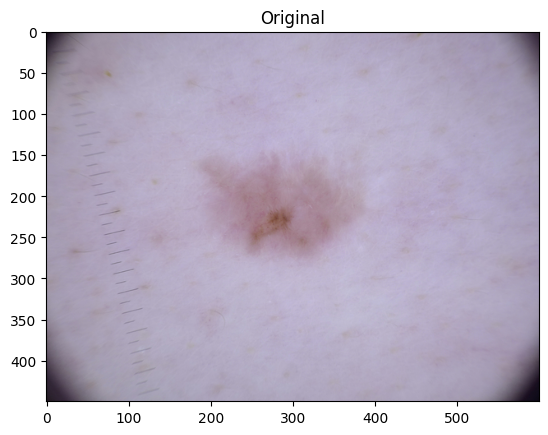

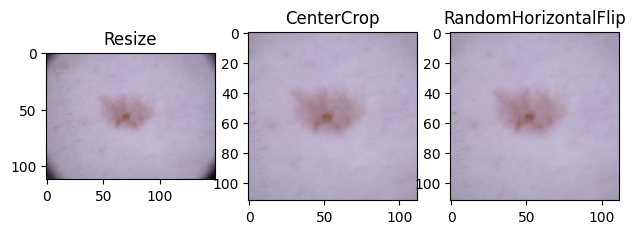

In [ ]:
# Code to visualize and decide data parameters
lesions = ISIC2018(train_df)

image, label = next(iter(lesions))

# Plot the original image
fig = plt.figure()
plt.imshow(image)
plt.title('Original')

# Transformations
resize = transforms.Resize(112)
crop = transforms.CenterCrop((112,112))
flip = transforms.RandomHorizontalFlip()

# Plot the image after the transformations
f = plt.figure(figsize=(10,10))
for i,tsfrm in enumerate([resize,crop,flip]):
  image = tsfrm(image)
  ax = f.add_subplot(1, 4, i + 1)
  ax.set_title(type(tsfrm).__name__)
  plt.imshow(image)

 ### First, import all libraries that used in this project

In [ ]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

#print(os.listdir("../input"))

In [ ]:
device = torch.device('cuda:0')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


## Step 1. Data analysis and preprocessing

Get the all image data paths， match the row information in HAM10000_metadata.csv with its corresponding image

This function is used to compute the mean and standard deviation on the whole dataset, will use for inputs normalization

Return the mean and std of RGB channels

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    print("imgs.shape")
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    i=2
    for i in range(3):
        print("Loop:" +str(i))
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        print("Loop:" +str(i)+".1")
        means.append(np.mean(pixels))
        print("Loop:" +str(i)+".2")
        stdevs.append(np.std(pixels))
        print("Loop:" +str(i)+".3")

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs


norm_mean,norm_std = compute_img_mean_std(all_image_path)
print(norm_mean)

print(norm_std)

In [ ]:

norm_mean,norm_std = [0.6843859, 0.5344464, 0.53196514], [0.2125198, 0.1949232, 0.20782322]

In [ ]:
df_original

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Benign keratosis-like lesions,2
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


Add three columns to the original DataFrame, path (image path), cell_type (the whole name),cell_type_idx (the corresponding index  of cell type, as the image label )

In [ ]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('cell_type_idx').count()
df_undup.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type
cell_type_idx,,,,,,,,,,,
0,327,327,327,327,327,327,327,327,327,327,327
1,514,514,514,514,514,514,514,514,514,514,514
2,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099
3,115,115,115,115,115,115,115,115,115,115,115
4,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705,6705


In [ ]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(val_df['image'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows
# create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image']
# apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(val_df))

8012
2003


In [ ]:
df_original['cell_type_idx'].value_counts()

,count
cell_type_idx,
4,6705
5,1113
2,1099
1,514
0,327
6,142
3,115


In [ ]:
val_df['cell_type'].value_counts()
val_df.size

24036

**From From the above statistics of each category, we can see that there is a serious class imbalance in the training data. To solve this problem, I think we can start from two aspects, one is equalization sampling, and the other is a loss function that can be used to mitigate category imbalance during training, such as focal loss.**

In [ ]:
import pandas as pd

# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

for i in range(7):
    if data_aug_rate[i] > 1: # Only augment if rate is > 1

        # 1. Select the rows for the current minority class
        minority_subset = df_train.loc[df_train['cell_type_idx'] == i, :]

        # 2. Create the list of DataFrames to concatenate (duplicating the subset)
        # We need (data_aug_rate[i] - 1) copies to achieve the total rate
        copies_list = [minority_subset] * (data_aug_rate[i] - 1)

        # 3. Use pd.concat() to add the copies to df_train
        # pd.concat takes a list of DataFrames: [original_df, augmented_df1, augmented_df2, ...]
        df_train = pd.concat(
            [df_train] + copies_list,
            ignore_index=True
        )

# Display the new class distribution
print(df_train['cell_type'].value_counts())

cell_type
Melanoma                         35600
Melanocytic nevi                  5364
Dermatofibroma                    4600
Benign keratosis-like lesions     4395
Basal cell carcinoma              4110
Actinic keratoses                 3930
Vascular lesions                   570
Name: count, dtype: int64


In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Create a copy of df_original to avoid modifying it in place
df_for_split = df_original.copy()

# Ensure 'cell_type_idx' is in df_for_split for the split operation.
# This re-creates it if it was removed by a prior operation or ensures it's current.
if 'cell_type_idx' not in df_for_split.columns:
    df_for_split['cell_type_idx'] = pd.Categorical(df_for_split['cell_type']).codes

# Separate features (X) and target (y) using column selection
y = df_for_split['cell_type_idx'].to_frame()
X = df_for_split.drop(columns=['cell_type_idx', 'train_or_val'], errors='ignore') # Drop target and temporary column if they exist

X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, stratify=y, test_size=0.2)

train_df = pd.concat([X_train_original, y_train_original], axis=1, sort=False)
train_df = train_df.reset_index(drop=True)

val_df = pd.concat([X_test_original, y_test_original], axis=1, sort=False)
val_df = val_df.reset_index(drop=True)

# Get class counts for the training set
class_counts = train_df['cell_type_idx'].value_counts()

# Calculate class weights for WeightedRandomSampler
num_samples = len(train_df)
num_classes = len(class_counts)

class_weights = {}
for class_id in class_counts.index:
    class_weights[class_id] = num_samples / (class_counts[class_id] * num_classes)

sample_weights = [class_weights[class_id] for class_id in train_df['cell_type_idx']]
sample_weights = torch.DoubleTensor(sample_weights)

weighted_sampler = torch.utils.data.sampler.WeightedRandomSampler(
    sample_weights,
    num_samples,
    replacement=True
)

print("Class weights calculated and WeightedRandomSampler prepared.")
print(f"Original training DataFrame size: {len(train_df)} rows")
print(f"Validation DataFrame size: {len(val_df)} rows")

Class weights calculated and WeightedRandomSampler prepared.
Original training DataFrame size: 8012 rows
Validation DataFrame size: 2003 rows


At the beginning, I divided the data into three parts, training set, validation set and test set. Considering the small amount of data, I did not further divide the validation set data in practice.

In [ ]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()

val_df = val_df.reset_index()
# df_test = df_test.reset_index()

In [ ]:
for index, rows in val_df.iterrows():
    # print(index, rows.path)
    if rows.path is None:
        val_df = val_df.drop(index)
    else:
        if rows.path.endswith('.png'):
            try:
                img = Image.open('./'+filename) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                val_df = val_df.drop(index)
                # print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
df_train.size

819966

In [ ]:
for index, rows in df_train.iterrows():
    # print(index, rows.path)
    if rows.path is None:
        df_train = df_train.drop(index)
    else:
        if rows.path.endswith('.png'):
            try:
                img = Image.open('./'+filename) # open the image file
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                df_train = df_train.drop(index)
                print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
df_train.head()

,index,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx,train_or_val
0,0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
1,1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
2,2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
3,3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4,train
4,4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5,train


In [ ]:
val_df.size
print(df_train.size)

819966


In [ ]:
val_df.head()

,index,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,dx,path,cell_type,cell_type_idx
0,0,ISIC_0033471,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
1,1,ISIC_0024479,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4
2,2,ISIC_0032777,0.0,0.0,1.0,0.0,0.0,0.0,0.0,BCC,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Basal cell carcinoma,1
3,3,ISIC_0033518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanoma,5
4,4,ISIC_0024762,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV,/content/drive/MyDrive/sanj/ISIC 2018/ISIC2018...,Melanocytic nevi,4


## Step 2. Model building

In [ ]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting.
# If feature_extract = False, the model is finetuned and all model parameters are updated.
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
import torch
import torch.nn as nn
from functools import partial
from einops import rearrange
from torchvision.models import resnet18, ResNet18_Weights

# --- START: DEPENDENCY HELPERS (Adapted from timm utilities) ---

# Utility to convert integer/list to 2-tuple (used for image/patch sizes)
def to_2tuple(x):
    if isinstance(x, (list, tuple)):
        return x
    return (x, x)

# Placeholder for DropPath (Stochastic Depth) functionality
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.training and self.drop_prob > 0.:
            # Simplified placeholder for stochastic depth
            keep_prob = 1 - self.drop_prob
            shape = (x.shape,) + (1,) * (x.ndim - 1)
            random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
            random_tensor.floor_()
            x = x.div(keep_prob) * random_tensor
        return x

def trunc_normal_(x, mean=0., std=1.):
    """Placeholder for initialization function."""
    nn.init.normal_(x, mean=mean, std=std)

# --- END: DEPENDENCY HELPERS ---


# --- START: CORE ViT COMPONENTS (From User's Input) ---

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, H, N, K)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Attention_Sup(nn.Module):
    ''' Add domain attention adaptation layer for ViT '''
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.,
                 r=2, num_domains=4,):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        # Domain adaptation layer
        hidden_dim = max(dim//r, 4)
        self.domain_layer = nn.Sequential(
            nn.Linear(num_domains, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, self.num_heads * head_dim),
        )

    def forward(self, x, domain_label):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to V: (B, H, N, K)
        x = attn @ v

        # Domain Attention Adaptation
        domain_att = self.domain_layer(domain_label).unsqueeze(2)  # (B, H*K, 1)
        domain_att = rearrange(domain_att, 'b (h k) c -> b h c k', h=self.num_heads).contiguous()  # (B, H, 1, K)
        domain_att = torch.softmax(domain_att, dim=1)  # (B, H, 1, K)
        x = domain_att * x  # Apply domain weighting to the attended value vector

        x = x.transpose(1, 2).contiguous().reshape(B, N, C)  # Reshape back to (B, N, C)

        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class Block_adapt(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 num_domains=4):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention_Sup(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop,
            num_domains=num_domains)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, domain_label):
        normed = self.norm1(x)
        # Pass domain_label to the custom Attention_Sup module
        x = x + self.drop_path(self.attn(normed, domain_label))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Standard Image to Patch Embedding """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0]) # Fixed here
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

# --- END: CORE ViT COMPONENTS ---


# --- START: HYBRID FUSION COMPONENTS (CNN Texture Extraction) ---

class HybridEmbed(nn.Module):
    """
    Hybrid Image to Patch Embedding (CNN Feature Extractor)
    Fuses CNN local features (texture) into ViT tokens (global spatial).
    """
    def __init__(self, backbone, img_size=224, in_chans=3, embed_dim=768):
        super().__init__()

        self.backbone = backbone

        # Get dynamic CNN feature characteristics
        feature_ratio = getattr(backbone, 'feature_ratio', 32)
        cnn_out_channels = getattr(backbone, 'num_features', 512)

        img_size = to_2tuple(img_size)

        num_patches_h = img_size[0] // feature_ratio # Fixed here
        num_patches_w = img_size[1] // feature_ratio
        self.num_patches = num_patches_h * num_patches_w

        # 1x1 Conv to project CNN channels (e.g., 512) to Transformer dimension (e.g., 768)
        self.proj = nn.Conv2d(cnn_out_channels, embed_dim, kernel_size=1, stride=1)

    def forward(self, x):
        # Stage 1: CNN Feature Extraction (captures local texture)
        x = self.backbone(x)

        # Stage 2: Channel Projection
        x = self.proj(x)

        # Flatten and transpose to create a sequence of tokens: (B, N_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        return x

def create_resnet_backbone(model_name='resnet18'):
    """Utility to create a pre-trained ResNet feature extractor."""
    if model_name == 'resnet18':
        # Load ResNet18 pre-trained on ImageNet for robust texture features
        backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Remove the final AvgPool and FC layer to output the 7x7 feature map (layer4)
        backbone_features = nn.Sequential(*list(backbone.children())[:-2])

        # Set attributes required by HybridEmbed
        setattr(backbone_features, 'num_features', 512) # ResNet18 Layer 4 output channels
        setattr(backbone_features, 'feature_ratio', 32) # Downsampling factor 224/7 = 32
        return backbone_features
    raise ValueError(f"Backbone model {model_name} not implemented.")

# --- END: HYBRID FUSION COMPONENTS ---


# --- START: MAIN ADAPTIVE HYBRID MODEL (VisionTransformer_adapt) ---

class VisionTransformer_adapt(nn.Module):
    """ Vision Transformer with Hybrid CNN input stage and Domain Adaptation blocks. """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm,
                 num_domains=4):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim

        if hybrid_backbone is not None:
            # Use HybridEmbed for CNN feature extraction and fusion
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            # Fallback to standard PatchEmbed
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)

        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule

        # Use Block_adapt which incorporates the domain label
        self.blocks = nn.ModuleList([
            Block_adapt(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[i],
                act_layer=nn.GELU,
                norm_layer=norm_layer,
                num_domains=num_domains
            )
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x, domain_label):
        B = x.shape[0] # Fixed: B = x.shape was causing a TypeError later
        x = self.patch_embed(x) # CNN extraction -> Feature tokens

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Pass domain_label through all adaptive blocks
        for blk in self.blocks:
            x = blk(x, domain_label)

        x = self.norm(x)
        return x[:, 0] # Return the CLS token for classification

    def forward(self, x, domain_label):
        x = self.forward_features(x, domain_label)
        x = self.head(x)
        return x

# --- END: MAIN ADAPTIVE HYBRID MODEL ---


# --- ISIC 2018 CUSTOMIZATION AND EXECUTION ---

# Configuration for ISIC 2018 (7 classes for Task 3)
NUM_CLASSES = 7
INPUT_SIZE = 224
EMBED_DIM = 768  # ViT Base size
DEPTH = 8        # Adjusted depth for better small-data adaptability
NUM_HEADS = 8
NUM_DOMAINS = 4  # Matches your example domain label input

# 1. Create the CNN Backbone (ResNet18 for local texture features)
cnn_backbone = create_resnet_backbone('resnet18')

# 2. Instantiate the Hybrid Model with custom parameters
# Passing the cnn_backbone activates the HybridEmbed fusion pathway.
net = VisionTransformer_adapt(
    img_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    hybrid_backbone=cnn_backbone,
    num_domains=NUM_DOMAINS
)

# 3. Execution Example (Using your input tensors)

# Input image batch (5 samples, 3 channels, 224x224)
x = torch.randn(5, 3, 224, 224)

# Domain labels (5 samples, one-hot encoded for 4 domains)
domain_label = torch.randint(0, NUM_DOMAINS, (5,))
domain_label = torch.nn.functional.one_hot(domain_label, NUM_DOMAINS).float()

# Forward pass through the Hybrid Model
y = net(x, domain_label)

print(f"Hybrid Model successfully initialized for {NUM_CLASSES} classes.")
print(f"Input image batch size (B, C, H, W): {x.shape}")
print(f"Input domain label batch size (B, N_Domains): {domain_label.shape}")
print(f"Output classification logits (Batch x Classes): {y.shape}")

Hybrid Model successfully initialized for 7 classes.
Input image batch size (B, C, H, W): torch.Size([5, 3, 224, 224])
Input domain label batch size (B, N_Domains): torch.Size([5, 4])
Output classification logits (Batch x Classes): torch.Size([5, 7])


In [ ]:
# --- ISIC 2018 CONFIGURATION ---
# ISIC 2018 Task 3 often involves 7 classes (MEL, NV, BCC, BKL, AKIEC, etc.)
NUM_CLASSES = 7
INPUT_SIZE = 224

# For small-data adaptation in medical imaging, we use a hybrid approach
# with shallower depth than standard ViT (12 blocks) to prevent overfitting.
EMBED_DIM = 768  # ViT Base size
DEPTH = 8        # Reduced depth for small-data stability [3]
NUM_HEADS = 8    # Corresponding number of heads
NUM_DOMAINS = 4  # Matches your example input tensor size

# 1. Instantiate the CNN Backbone (ResNet18 for initial texture features)
cnn_backbone = create_resnet_backbone('resnet18')

# 2. Instantiate the Hybrid Model
# This automatically uses HybridEmbed because 'hybrid_backbone' is provided,
# effectively fusing the CNN and ViT components.
net = VisionTransformer_adapt(
    img_size=INPUT_SIZE,
    in_chans=3,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    hybrid_backbone=cnn_backbone, # <-- Integrates CNN output as tokens
    num_domains=NUM_DOMAINS       # <-- Supports your domain adaptation blocks
)

# --- EXECUTION EXAMPLE (Your original test case) ---

# Input image batch (5 samples, 3 channels, 224x224)
x = torch.randn(5, 3, 224, 224)

# Domain labels (5 samples, one-hot encoded for 4 domains)
domain_label = torch.randint(0, NUM_DOMAINS, (5,))
domain_label = torch.nn.functional.one_hot(domain_label, NUM_DOMAINS).float()

# Forward pass through the Hybrid Model
# The forward pass now performs CNN feature extraction followed by
# Transformer global attention with domain adaptation.
y = net(x, domain_label)

print(f"Hybrid Model successfully initialized for {NUM_CLASSES} classes.")
print(f"Output shape (Batch x Classes): {y.shape}")

Hybrid Model successfully initialized for 7 classes.
Output shape (Batch x Classes): torch.Size([5, 7])


In [ ]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        #print(X)
        #plt.imshow(X)
        #plt.show()
        y = torch.tensor(int(self.df['cell_type_idx'][index]))
        #print(torch.tensor(int(self.df['cell_type_idx'][index])))

        if self.transform:
            X = self.transform(X)

        return X, y

In [ ]:
import torch
from torchvision import transforms
from torchvision.transforms import functional as F
import numpy as np

# --- Configuration for Normalization and Size ---
# These are the standard ImageNet statistics, essential for pre-trained CNN backbones (ResNet) [3]
norm_mean = (0.485, 0.456, 0.406) # Using standard ImageNet values for better pre-training match
norm_std = (0.229, 0.224, 0.225)  # Using standard ImageNet values
input_size = 224 # Must match your model's expected input resolution


# --- ENHANCED TRAINING TRANSFORMS ---
# This policy is robust and includes TrivialAugment for better data diversity.

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size), # Resize and crop to the model's input size
    transforms.TrivialAugmentWide(),
    # Final conversion and normalization
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# --- VALIDATION/TEST TRANSFORMS ---
# Must remain deterministic (no random operations).

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

print("The augmented transforms are defined using TrivialAugmentWide for enhanced data diversity.")

The augmented transforms are defined using TrivialAugmentWide for enhanced data diversity.


In [ ]:
# Define the training set using the table train_df and using our defined transitions (train_transform)
training_set = HAM10000(train_df, transform=train_transform)

# Use the weighted_sampler for the training DataLoader
train_loader = DataLoader(training_set, batch_size=32, sampler=weighted_sampler, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(val_df, transform=val_transform) # Using val_transform for validation
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from collections import Counter
import os

# --- Configuration Constants ---
NUM_CLASSES = 7  # 7 classes for ISIC 2018 / HAM10000
NUM_DOMAINS = 4  # Must match the 'num_domains' set in VisionTransformer_adapt
INPUT_SIZE = 224 # Match your model's expected input resolution

# --- 1. Corrected Data Augmentation Definitions ---
# Using standard ImageNet statistics for consistency with pre-trained CNN backbone [1]
norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)

# # Enhanced Training Transforms (Includes resizing and robust augmentation like TrivialAugment)
# train_transform = transforms.Compose(
#     # If TrivialAugment is not available, use the robust geometric/color set you defined earlier:
#     # transforms.RandomHorizontalFlip(),
#     # transforms.RandomVerticalFlip(),
#     # transforms.RandomRotation(20),
#     # transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),

#     transforms.TrivialAugmentWide(), # Robust, automated augmentation policy
#     transforms.ToTensor(),
#     transforms.Normalize(norm_mean, norm_std)
# ])

# # Validation/Test Transforms (Deterministic)
# val_transform = transforms.Compose()


# --- 2. Custom Dataset Class (HAM10000 / ISIC 2018) ---

class SkinLesionDataset(Dataset):
    """
    Custom Dataset to load image, label, and required domain_label for HSLT.
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.num_domains = NUM_DOMAINS

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]

        # --- 1. Load Data and Get Label ---
        # Assuming 'path' column contains the full image file path
        X = Image.open(row['path']).convert('RGB')

        # Assuming 'cell_type_idx' column contains the integer label (0-6)
        y = torch.tensor(int(row['cell_type_idx']), dtype=torch.long)

        # Apply transforms
        if self.transform:
            X = self.transform(X)

        # --- 2. Generate Domain Label (Crucial for VisionTransformer_adapt) ---
        # NOTE: Verify the source of your 'center_id' or domain metadata
        if 'center_id' in self.df.columns:
            domain_idx = int(row['center_id']) % self.num_domains
        else:
            # Placeholder: Simulating domain based on index if no domain column exists
            domain_idx = index % self.num_domains

        # Create a one-hot encoded domain vector
        domain_label = torch.zeros(self.num_domains, dtype=torch.float)
        domain_label[domain_idx] = 1.0

        # Return image, classification label, and domain label
        return X, y, domain_label


# --- 3. Imbalance Mitigation: Weighted Sampler Calculation ---

def get_sampler_weights(df):
    """
    Calculates weights for WeightedRandomSampler based on inverse class frequency.
    This ensures minority classes (like Melanoma) are sampled more frequently.
    """
    labels = df['cell_type_idx'].values
    class_counts = Counter(labels)
    num_samples = len(labels)

    # Calculate inverse frequency weight: wi = Total_Samples / Class_Count
    weights = {cls: num_samples / (class_counts[cls]) for cls in class_counts}

    sample_weights = [weights[label] for label in labels]

    weighted_sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=num_samples,
        replacement=True
    )
    return weighted_sampler, weights


# --- 4. DataLoader Setup and Initialization ---

# NOTE: Ensure 'train_df' and 'val_df' are defined in your notebook,
# loaded with 'path' and 'cell_type_idx' columns.

# --- Training Set Setup ---
training_set = SkinLesionDataset(train_df, transform=train_transform)

# Calculate weights and create the sampler
weighted_sampler, class_weights_map = get_sampler_weights(train_df)
print(f"Calculated Class Weights for Sampler: {class_weights_map}")

# Use the weighted_sampler for the training DataLoader
train_loader = DataLoader(
    training_set,
    batch_size=32,
    sampler=weighted_sampler, # <-- Use the weighted sampler
    num_workers=4,
    pin_memory=True
)

# --- Validation Set Setup ---
validation_set = SkinLesionDataset(val_df, transform=val_transform)

# Validation should not use weighted sampling
val_loader = DataLoader(
    validation_set,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# --- Loss Function Weights for Weighted Cross-Entropy ---
loss_weights = torch.tensor(
    [class_weights_map[i] for i in range(NUM_CLASSES)],
    dtype=torch.float
)

print(f"Loss Function Weights (Tensor for CrossEntropyLoss): {loss_weights}")

Calculated Class Weights for Sampler: {np.int8(4): 1.493661446681581, np.int8(5): 9.002247191011236, np.int8(1): 19.49391727493917, np.int8(2): 9.11490329920364, np.int8(3): 87.08695652173913, np.int8(6): 70.28070175438596, np.int8(0): 30.580152671755727}
Loss Function Weights (Tensor for CrossEntropyLoss): tensor([30.5802, 19.4939,  9.1149, 87.0870,  1.4937,  9.0022, 70.2807])


1
2


torch.Size([32, 3, 224, 224])


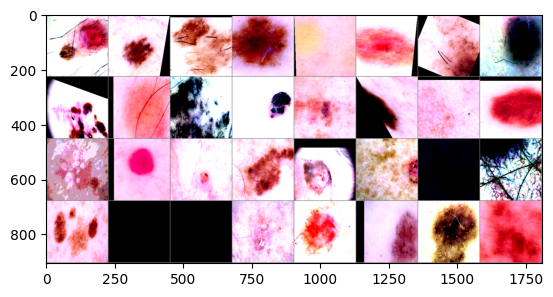

NV
DF
BKL
DF
BCC
BKL
DF
VASC
DF
BKL
DF
VASC
NV
DF
MEL
BKL
AKIEC
VASC
NV
DF
BCC
NV
AKIEC
BKL
BCC
BKL
DF
MEL
NV
DF
BKL
BKL


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
batch_size=32
# functions to show an image


print("1")

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print("2")
# get some random training images
dataiter = iter(train_loader)
images, labels, _ = next(dataiter)
print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
keys_list = list(lesion_type_dict.keys())
for j in range(batch_size):
    # Ensure labels[j] is a valid index for keys_list
    if labels[j] < len(keys_list):
        print( keys_list[labels[j]])
    else:
        print(f"Label index {labels[j]} out of bounds for keys_list ({len(keys_list)} elements).")


#print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


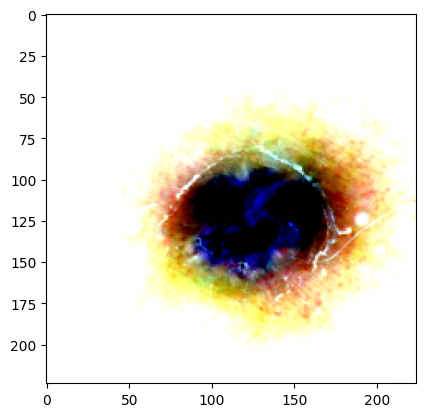

In [ ]:
dataiter = iter(train_loader)
images, labels, _ = next(dataiter) # Unpack 3 values, ignoring the domain_label
plt.imshow(np.transpose(images[1]))

In [ ]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# --- Configuration (Must match your setup) ---
NUM_CLASSES = 7
NUM_DOMAINS = 4
NUM_EPOCHS = 20 # Target: 20 epochs for initial assessment

# Assuming 'net' (VisionTransformer_adapt) is initialized here
# Assuming 'train_loader', 'val_loader', and 'loss_weights' are calculated
# and defined using the data loading script provided previously.

# --- 1. Device Setup and Model Initialization ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Initialize Model (Ensure 'net' object is defined in your environment)
# net = VisionTransformer_adapt(...)
net.to(DEVICE)

# Move weights for CrossEntropyLoss to the device
# The loss_weights tensor must be defined from your data loading step.
# Example definition for demonstration (Replace with actual calculated weights):
# loss_weights = torch.tensor([0.1, 0.05, 0.2, 0.3, 0.1, 0.15, 0.1], dtype=torch.float)
loss_weights = loss_weights.to(DEVICE)

# --- 2. Loss and Optimizer Configuration ---

# Criterion: Weighted Cross-Entropy Loss [1]
# This penalizes errors on rare classes (like Melanoma) more heavily,
# directly improving performance on the challenging minority classes.
criterion = nn.CrossEntropyLoss(weight=loss_weights)

# Optimizer: AdamW
# Recommended for large Transformer-based models for stable training [2]
optimizer = optim.AdamW(net.parameters(), lr=1e-4, weight_decay=0.01)

# Learning Rate Scheduler (Optional but Recommended for better convergence)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


# --- 3. Training and Validation Functions ---

def train_one_epoch(model, data_loader, criterion, optimizer, device):
    """Handles the training logic for a single epoch."""
    model.train()
    total_loss = 0

    for batch_idx, (images, labels, domain_labels) in enumerate(data_loader):

        # Move data to the appropriate device
        images = images.to(device)
        labels = labels.to(device)
        domain_labels = domain_labels.to(device) # Required for VisionTransformer_adapt

        optimizer.zero_grad()

        # Forward pass: Hybrid model requires both image and domain label input
        outputs = model(images, domain_labels)
        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(data_loader.dataset)

def validate_model(model, data_loader, device):
    """Evaluates the model on the validation set."""
    model.eval()
    # Change AverageMeter to simple lists for collecting all predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, domain_labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)
            domain_labels = domain_labels.to(device)

            outputs = model(images, domain_labels)
            _, predicted = torch.max(outputs.data, 1)

            # Append batch predictions and labels to lists
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics (Accuracy is the primary request)
    accuracy = accuracy_score(all_labels, all_preds)

    # Calculate Macro F1-Score (better metric for imbalanced data)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, macro_f1


# --- 4. Main Training Execution Loop ---

print("\n--- Starting Hybrid Model Training for 20 Epochs ---")
start_time = time.time()
best_val_f1 = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()

    # 1. Training Phase
    train_loss = train_one_epoch(net, train_loader, criterion, optimizer, DEVICE)

    # 2. Validation Phase
    val_accuracy, val_macro_f1 = validate_model(net, val_loader, DEVICE)

    # 3. Update Learning Rate Scheduler
    scheduler.step(val_macro_f1)

    epoch_duration = time.time() - epoch_start_time

    print(f"Epoch {epoch}/{NUM_EPOCHS} | Duration: {epoch_duration:.2f}s | ",
          f"Train Loss: {train_loss:.4f} | ",
          f"Val Acc: {val_accuracy * 100:.2f}% | ",
          f"Val Macro F1: {val_macro_f1:.4f}")

    # Save the best model based on Macro F1 (recommended for imbalanced data)
    if val_macro_f1 > best_val_f1:
        best_val_f1 = val_macro_f1
        torch.save(net.state_dict(), 'best_hybrid_model.pth')
        print(f"*** Model Saved: New best Macro F1 achieved ({best_val_f1:.4f}) ***")


end_time = time.time()
print(f"\n--- Training Complete ---")
print(f"Total time: {(end_time - start_time) / 60:.2f} minutes")
print(f"Best Validation Macro F1 achieved: {best_val_f1:.4f}")

Using device: cuda:0

--- Starting Hybrid Model Training for 20 Epochs ---


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 1/20 | Duration: 567.32s |  Train Loss: 0.6738 |  Val Acc: 20.07% |  Val Macro F1: 0.3097
*** Model Saved: New best Macro F1 achieved (0.3097) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 2/20 | Duration: 216.14s |  Train Loss: 0.5665 |  Val Acc: 19.77% |  Val Macro F1: 0.2832


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 3/20 | Duration: 186.25s |  Train Loss: 0.4901 |  Val Acc: 22.47% |  Val Macro F1: 0.4179
*** Model Saved: New best Macro F1 achieved (0.4179) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 4/20 | Duration: 167.40s |  Train Loss: 0.4628 |  Val Acc: 22.92% |  Val Macro F1: 0.3425


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 5/20 | Duration: 151.02s |  Train Loss: 0.4404 |  Val Acc: 24.26% |  Val Macro F1: 0.4207
*** Model Saved: New best Macro F1 achieved (0.4207) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 6/20 | Duration: 150.08s |  Train Loss: 0.4137 |  Val Acc: 46.83% |  Val Macro F1: 0.5056
*** Model Saved: New best Macro F1 achieved (0.5056) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 7/20 | Duration: 138.95s |  Train Loss: 0.3987 |  Val Acc: 30.35% |  Val Macro F1: 0.4327


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 8/20 | Duration: 135.70s |  Train Loss: 0.3920 |  Val Acc: 49.28% |  Val Macro F1: 0.5134
*** Model Saved: New best Macro F1 achieved (0.5134) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 9/20 | Duration: 133.03s |  Train Loss: 0.3517 |  Val Acc: 48.33% |  Val Macro F1: 0.4818


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 10/20 | Duration: 131.64s |  Train Loss: 0.3594 |  Val Acc: 57.06% |  Val Macro F1: 0.5297
*** Model Saved: New best Macro F1 achieved (0.5297) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 11/20 | Duration: 128.07s |  Train Loss: 0.3456 |  Val Acc: 57.11% |  Val Macro F1: 0.5625
*** Model Saved: New best Macro F1 achieved (0.5625) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 12/20 | Duration: 128.34s |  Train Loss: 0.3285 |  Val Acc: 48.88% |  Val Macro F1: 0.4805


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 13/20 | Duration: 129.79s |  Train Loss: 0.3367 |  Val Acc: 53.22% |  Val Macro F1: 0.4901


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 14/20 | Duration: 130.03s |  Train Loss: 0.3010 |  Val Acc: 48.93% |  Val Macro F1: 0.5100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 15/20 | Duration: 128.68s |  Train Loss: 0.3290 |  Val Acc: 58.96% |  Val Macro F1: 0.5384


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 16/20 | Duration: 126.90s |  Train Loss: 0.2543 |  Val Acc: 60.01% |  Val Macro F1: 0.6063
*** Model Saved: New best Macro F1 achieved (0.6063) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 17/20 | Duration: 128.42s |  Train Loss: 0.2512 |  Val Acc: 59.71% |  Val Macro F1: 0.5692


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 18/20 | Duration: 126.83s |  Train Loss: 0.2376 |  Val Acc: 63.65% |  Val Macro F1: 0.6192
*** Model Saved: New best Macro F1 achieved (0.6192) ***


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 19/20 | Duration: 126.13s |  Train Loss: 0.2462 |  Val Acc: 61.46% |  Val Macro F1: 0.5809


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 20/20 | Duration: 127.78s |  Train Loss: 0.2431 |  Val Acc: 63.01% |  Val Macro F1: 0.6318
*** Model Saved: New best Macro F1 achieved (0.6318) ***

--- Training Complete ---
Total time: 54.68 minutes
Best Validation Macro F1 achieved: 0.6318


My Strategy to improve Model Accuracy
1.   Loss Function Upgrade: I'm replacing the current weighted loss with Focal Loss. This will shift training focus dynamically onto the hardest-to-classify examples, improving feature discrimination for confusing lesions.

2.   Extended Training: I will run 30–60 epochs of training instead of 20, as the Validation Macro F1 was still increasing. The existing schedulers and saving mechanisms will ensure I capture the best model.
